## Assignment

In this assignment, you'll continue working with the house prices data. To complete this assignment, submit a link to a Jupyter notebook containing your solutions to the following tasks:

* Load the **houseprices** data from Thinkful's database.
* Reimplement your model from the previous checkpoint.
* Try OLS, Lasso, Ridge, and ElasticNet regression using the same model specification. This time, you need to do **k-fold cross-validation** to choose the best hyperparameter values for your models. Scikit-learn has RidgeCV, LassoCV, and ElasticNetCV that you can utilize to do this. Which model is the best? Why?

This is not a graded checkpoint, but you should discuss your solution with your mentor. After you've submitted your work, take a moment to compare your solution to [this example solution](https://github.com/Thinkful-Ed/machine-learning-regression-problems/blob/master/notebooks/7.solution_overfitting_and_regularization.ipynb).

In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.metrics import mean_absolute_error

import ds_useful

[My Useful Data Science Functions](https://github.com/cobyoram/python-for-data-scientists/blob/master/ds_useful.py)

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'
table = postgres_db

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

data = pd.read_sql_query('SELECT * FROM {}'.format(table), con=engine)

engine.dispose()

In [3]:
prices = data.copy()
target_name = 'saleprice'

print(prices[target_name].head())
prices.head()

0    208500
1    181500
2    223500
3    140000
4    250000
Name: saleprice, dtype: int64


id  mssubclass mszoning  lotfrontage  lotarea street alley lotshape  \
0   1          60       RL         65.0     8450   Pave  None      Reg   
1   2          20       RL         80.0     9600   Pave  None      Reg   
2   3          60       RL         68.0    11250   Pave  None      IR1   
3   4          70       RL         60.0     9550   Pave  None      IR1   
4   5          60       RL         84.0    14260   Pave  None      IR1   

  landcontour utilities  ... poolarea poolqc fence miscfeature miscval mosold  \
0         Lvl    AllPub  ...        0   None  None        None       0      2   
1         Lvl    AllPub  ...        0   None  None        None       0      5   
2         Lvl    AllPub  ...        0   None  None        None       0      9   
3         Lvl    AllPub  ...        0   None  None        None       0      2   
4         Lvl    AllPub  ...        0   None  None        None       0     12   

  yrsold  saletype  salecondition  saleprice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [4]:
# Drop the rest of missing columns, rather than interpolating
missings = ds_useful.missingness_summary(prices)
prices.drop(missings.loc[missings > 5].index, axis=1, inplace=True)

# # Get percentages of repeated zeros in data and Remove columns with more htan 90% 0
repeats = ds_useful.repeats_summary(prices, value=0)
prices.drop(repeats.loc[repeats > 90].index, axis=1, inplace=True)

# Now binary encode data with a lot of repeated zeros
repeats = ds_useful.repeats_summary(prices, value=0)
num_binaries = repeats.loc[repeats > 50].index
for col in num_binaries:
    prices[col] = np.where(prices[col] == 0, 0, 1)

# Do the same with repeated modes (more than 90% is mode)
cat_repeats = ds_useful.repeats_summary(prices, value_agg='mode')
prices.drop(cat_repeats.loc[cat_repeats > 90].index, axis=1)

# Get repeating zeros again
repeats = ds_useful.repeats_summary(prices, value=0)
num_binaries = repeats.loc[repeats > 50].index
for col in num_binaries:
    prices[col] = np.where(prices[col] == prices[col].mode().iloc[0], 0, 1)

# Get rid of the rest of the missing rows
prices.dropna(axis=0, inplace=True)

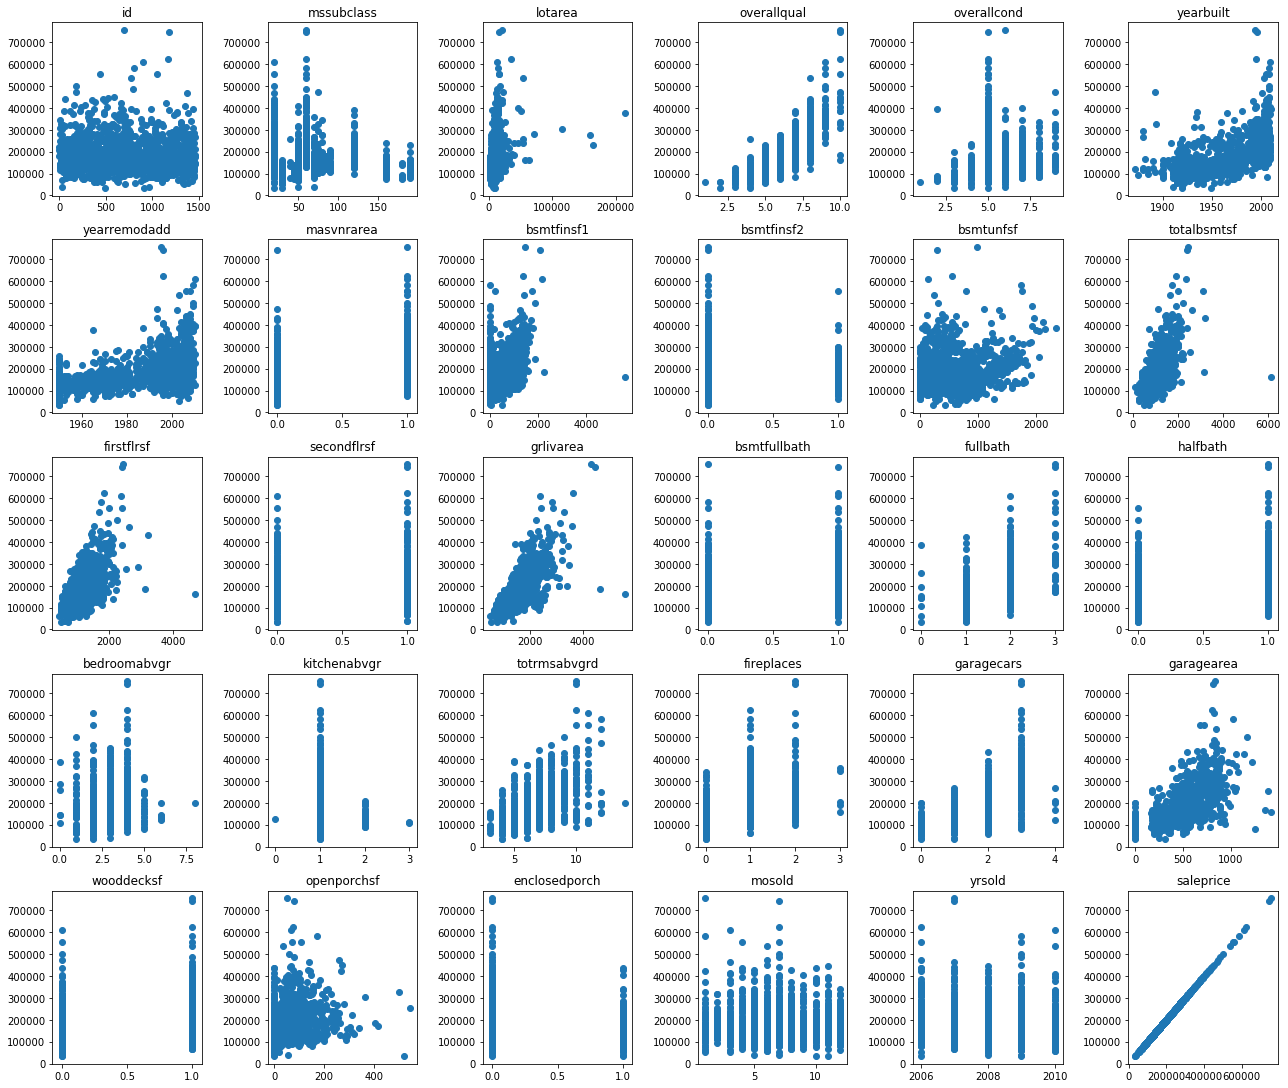

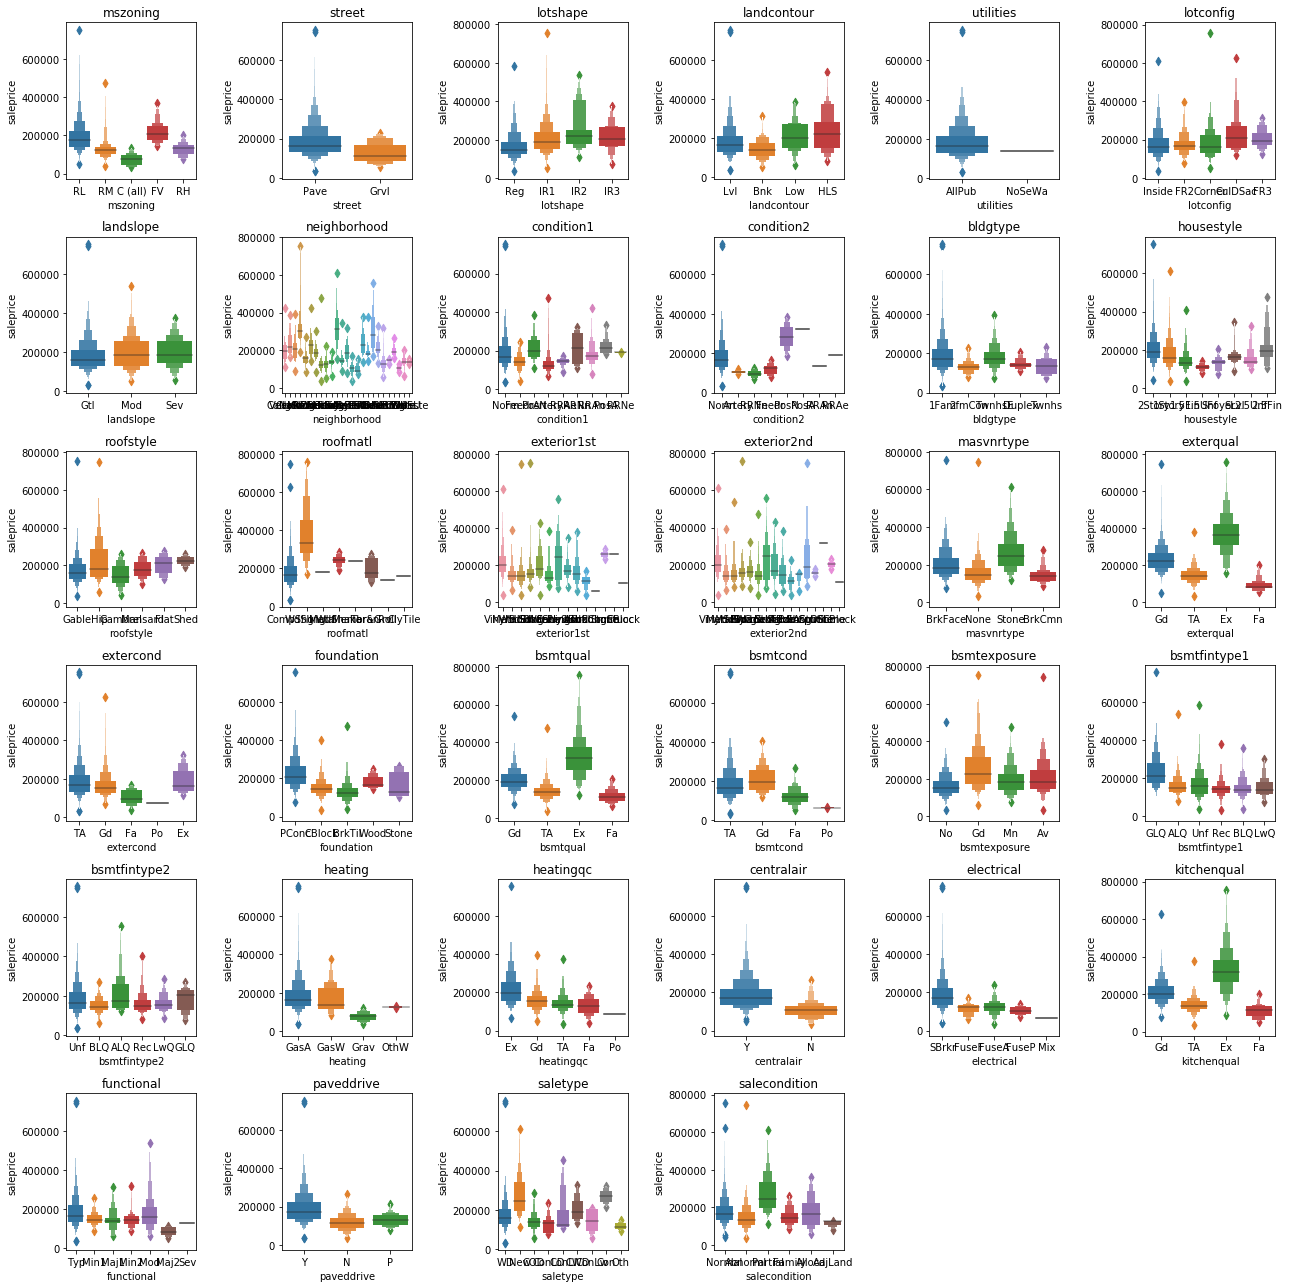

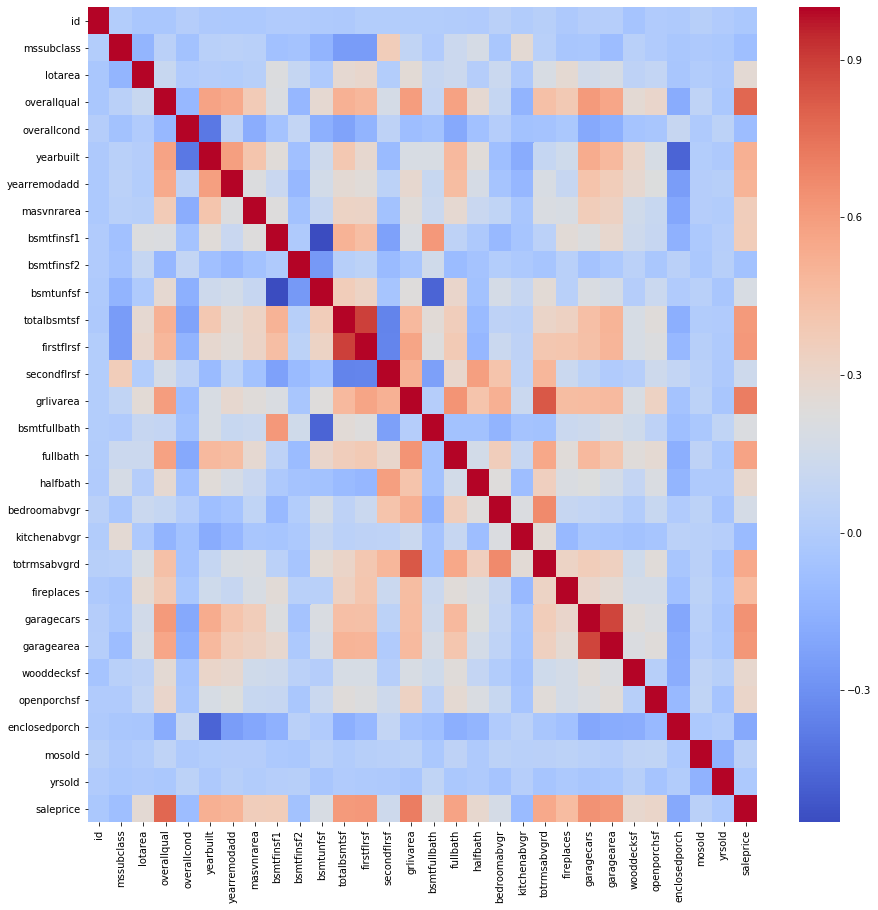

In [5]:
# First thing's first, I'll look at my variables

def plot_cat(df, col, y):
    sns.boxenplot(x=df[col], y=y)

def plot_num(df, col, y):
    plt.scatter(df[col], y)

ds_useful.make_subplots(prices.select_dtypes('number'), plot_num, [prices['saleprice']])
ds_useful.make_subplots(prices.select_dtypes('object'), plot_cat, [prices['saleprice']])
plt.figure(figsize=(15,15))
sns.heatmap(data=prices.corr(), cmap='coolwarm')
plt.show()

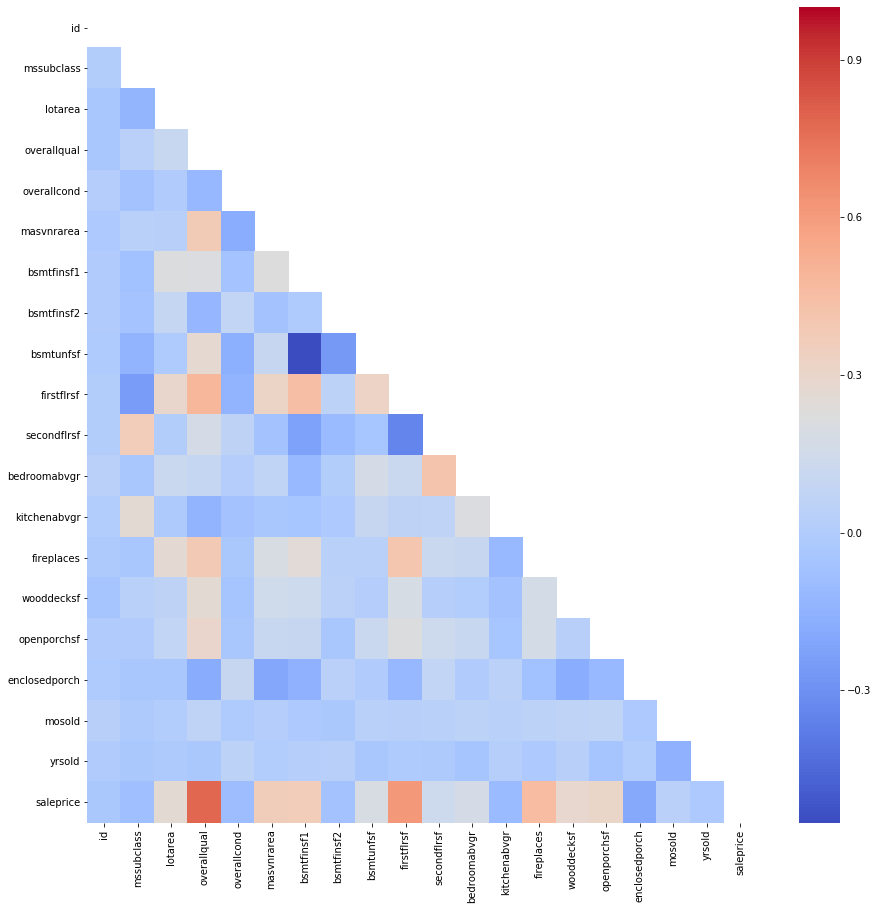

In [6]:
# First, we'll remove collinear variables
ds_useful.remove_correlated_features(prices, target_name, .5)
plt.figure(figsize=(15,15))
mask = np.triu(np.ones_like(prices.corr(), dtype=np.bool))
sns.heatmap(data=prices.corr(), mask=mask, cmap='coolwarm')
plt.show()

In [7]:
# Get outliers and work on that
outliers = ds_useful.outliers_summary(prices, 3)

# Reduce outliers list to those that are continuous
for col in outliers.index:
    if prices[col].nunique() < 20:
        outliers.drop(col, inplace=True)

# Winsorize the data
for column in outliers.index:
    percentiles = ds_useful.get_percentiles(prices, column, 3)
    prices[column] = stats.mstats.winsorize(prices[column], percentiles)

In [8]:
# Use an anova test to weed out some categorical variables
insig_cols = ds_useful.get_significant_category_columns(prices, target_name, sig=False)

prices.drop(insig_cols, axis=1, inplace=True)

In [9]:
# Sort continuous variables by their correlation to the target, then only keep the top 5
def sort_by_correlation(df, target_name, sort='desc', abs=True):
    corr_df = df.corr()
    if sort=='asc':
        ascending=True
    elif sort == 'desc':
        ascending=False
    corr = corr_df[target_name].copy()
    if abs:
        corr = np.abs(corr)
    corr.sort_values(ascending=ascending, inplace=True)
    return corr

sort_corr_cols = sort_by_correlation(prices, target_name)

keep_continuous = sort_corr_cols.head(5).index

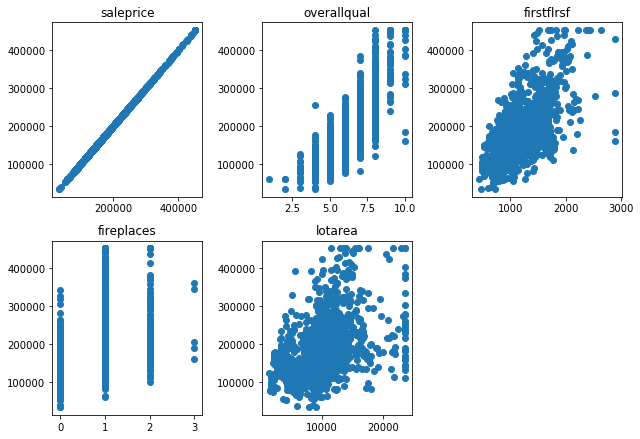

In [10]:
ds_useful.make_subplots(prices[keep_continuous], plot_num, [prices[target_name]])

In [11]:
# Sort categorical variables by those with the most variability among their unique groups

def sort_by_categorical_var(df, target_name, sort='desc'):
    cat_cols = df.select_dtypes('object').columns
    stds = []
    for col in cat_cols:
        cats = df[col].unique()
        cat_means = [df.loc[df[col]==cat,target_name].mean() for cat in cats]
        col_std = np.std(cat_means)
        stds.append(col_std)
    s = pd.Series(stds, index=cat_cols)
    if sort=='asc':
        ascending = True
    elif sort=='desc':
        ascending=False
    s.sort_values(ascending = ascending, inplace=True)
    return s

sort_var_cols = sort_by_categorical_var(prices, target_name)

keep_categorical = sort_var_cols.head(5).index

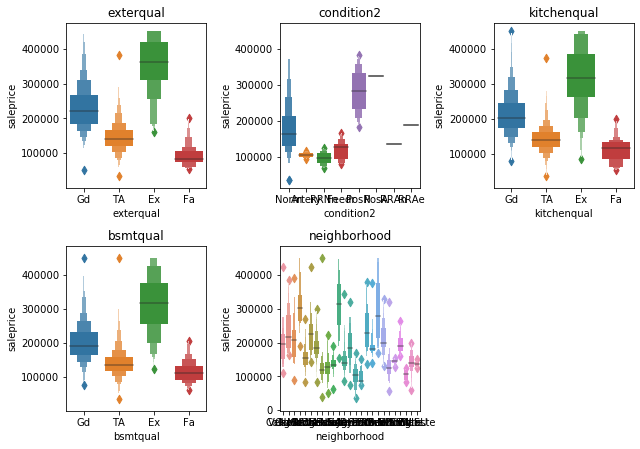

In [12]:
ds_useful.make_subplots(prices[keep_categorical], plot_cat, [prices[target_name]])

In [13]:
neigh = np.where(prices['neighborhood'] == prices['neighborhood'].value_counts().index[0], 1, 0)
neighborhood = pd.Series(neigh, index=prices['neighborhood'].index)

keep_categorical.drop('neighborhood')
neighborhood.value_counts()

0    1197
1     215
dtype: int64

In [14]:
dummies = pd.get_dummies(prices[keep_categorical], drop_first=True)
dummies

exterqual_Fa  exterqual_Gd  exterqual_TA  condition2_Feedr  \
0                0             1             0                 0   
1                0             0             1                 0   
2                0             1             0                 0   
3                0             0             1                 0   
4                0             1             0                 0   
...            ...           ...           ...               ...   
1455             0             0             1                 0   
1456             0             0             1                 0   
1457             0             0             0                 0   
1458             0             0             1                 0   
1459             0             1             0                 0   

      condition2_Norm  condition2_PosA  condition2_PosN  condition2_RRAe  \
0                   1                0                0                0   
1                   1                0                0                0   
2                   1                0                0                0   
3                   1                0                0                0   
4                   1                0                0                0   
...               ...              ...              ...              ...   
1455                1                0                0                0   
1456                1                0                0                0   
1457                1                0                0                0   
1458                1                0                0                0   
1459                1                0                0                0   

      condition2_RRAn  condition2_RRNn  ...  neighborhood_NoRidge  \
0                   0                0  ...                     0   
1                   0                0  ...                     0   
2                   0                0  ...                     0   
3                   0                0  ...                     0   
4                   0                0  ...                     1   
...               ...              ...  ...                   ...   
1455                0                0  ...                     0   
1456                0                0  ...                     0   
1457                0                0  ...                     0   
1458                0                0  ...                     0   
1459                0                0  ...                     0   

      neighborhood_NridgHt  neighborhood_OldTown  neighborhood_SWISU  \
0                        0                     0                   0   
1                        0                     0                   0   
2                        0                     0                   0   
3                        0                     0                   0   
4                        0                     0                   0   
...                    ...                   ...                 ...   
1455                     0                     0                   0   
1456                     0                     0                   0   
1457                     0                     0                   0   
1458                     0                     0                   0   
1459                     0                     0                   0   

      neighborhood_Sawyer  neighborhood_SawyerW  neighborhood_Somerst  \
0                       0                     0                     0   
1                       0                     0                     0   
2                       0                     0                     0   
3                       0                     0                     0   
4                       0                     0                     0   
...                   ...                   ...                   ...   
1455                    0                     0                     0  

In [15]:
# Join all our pieces together
houseprices = pd.concat([
    prices[keep_continuous],
    dummies,
    pd.DataFrame(neighborhood)
], axis=1)

houseprices

saleprice  overallqual  firstflrsf  fireplaces  lotarea  exterqual_Fa  \
0        208500            7         856           0     8450             0   
1        181500            6        1262           1     9600             0   
2        223500            7         920           1    11250             0   
3        140000            7         961           1     9550             0   
4        250000            8        1145           1    14260             0   
...         ...          ...         ...         ...      ...           ...   
1455     175000            6         953           1     7917             0   
1456     210000            6        2073           2    13175             0   
1457     266500            7        1188           2     9042             0   
1458     142125            5        1078           0     9717             0   
1459     147500            5        1256           0     9937             0   

      exterqual_Gd  exterqual_TA  condition2_Feedr  condition2_Norm  ...  \
0                1             0                 0                1  ...   
1                0             1                 0                1  ...   
2                1             0                 0                1  ...   
3                0             1                 0                1  ...   
4                1             0                 0                1  ...   
...            ...           ...               ...              ...  ...   
1455             0             1                 0                1  ...   
1456             0             1                 0                1  ...   
1457             0             0                 0                1  ...   
1458             0             1                 0                1  ...   
1459             1             0                 0                1  ...   

      neighborhood_NridgHt  neighborhood_OldTown  neighborhood_SWISU  \
0                        0                     0                   0   
1                        0                     0                   0   
2                        0                     0                   0   
3                        0                     0                   0   
4                        0                     0                   0   
...                    ...                   ...                 ...   
1455                     0                     0                   0   
1456                     0                     0                   0   
1457                     0                     0                   0   
1458                     0                     0                   0   
1459                     0                     0                   0   

      neighborhood_Sawyer  neighborhood_SawyerW  neighborhood_Somerst  \
0                       0                     0                     0   
1                       0                     0                     0   
2                       0                     0                     0   
3                       0                     0                     0   
4                       0                     0                     0   
...                   ...                   ...                   ...   
1455                    0                     0                     0   
1456                    0                     0                     0   
1457                    0                     0                     0   
1458                    0                     0                     0   
1459                    0                     0                     0   

      neighborhood_StoneBr  neighborhood_Timber  neighborhood_Veenker  0  
0                        0                    0                     0  0  
1                        0                    0                     1  0  
2                        0                    0                     0  0  
3                        0                    0                     0  0  
4                        0 

## Model the data

In [16]:
X = houseprices.drop(target_name, axis=1)
y = houseprices[target_name]

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

lrm = sm.OLS(y_train, X_train)
results = lrm.fit()

results_summary = results.summary()
print(results_summary)

OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     135.5
Date:                Thu, 20 Feb 2020   Prob (F-statistic):               0.00
Time:                        01:14:34   Log-Likelihood:                -13210.
No. Observations:                1129   AIC:                         2.651e+04
Df Residuals:                    1084   BIC:                         2.674e+04
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 5.481e+04   3.38e+04      1.623      0

The performance metrics seem satisfactory. There is a mix between significant and insignificant coefficients. The r-squared and adjusted R-squared seem good, along with the f-statistic. The AIC and BIC are hanging around 2600. Let's see how it holds up with test data.

## Analyze the model

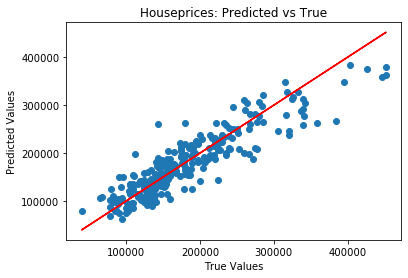

Mean absolute error of the prediction is: 23132.82725834426
Mean squared error of the prediction is: 984599218.5804012
Root mean squared error of the prediction is: 31378.3240244026
Mean absolute percentage error of the prediction is: 13.857177726011283


In [17]:
# make predictions and test them against true test values

y_test_pred = results.predict(X_test)

plt.scatter(y_test, y_test_pred)
plt.plot(y_test, y_test, color='r')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Houseprices: Predicted vs True')
plt.show()

def print_evaluation_metrics(true, predicted):
    print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(true, predicted)))
    print("Mean squared error of the prediction is: {}".format(mse(true, predicted)))
    print("Root mean squared error of the prediction is: {}".format(rmse(true, predicted)))
    print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((true - predicted) / y_test)) * 100))

print_evaluation_metrics(y_test, y_test_pred)

I wouldn't be tempted to say that this is fantastic. Perhaps we should try eliminating some of those less significant columns.

In [21]:
# Put results into a pd.DataFrame

# Note that tables is a list. The table at index 1 is the "core" table. Additionally, read_html puts dfs in a list, so we want index 0
results_as_html = results_summary.tables[1].as_html()
results_table = pd.read_html(results_as_html, header=0, index_col=0)[0]
results_table

coef    std err       t  P>|t|      [0.025  \
const                 54810.0000  33800.000   1.623  0.105  -11500.000   
overallqual           16070.0000   1212.233  13.259  0.000   13700.000   
firstflrsf               32.2137      3.268   9.856  0.000      25.801   
fireplaces             9732.3951   1694.695   5.743  0.000    6407.141   
lotarea                   3.2043      0.287  11.171  0.000       2.642   
exterqual_Fa         -19580.0000  12100.000  -1.616  0.106  -43400.000   
exterqual_Gd         -14510.0000   6157.937  -2.356  0.019  -26600.000   
exterqual_TA         -20280.0000   6841.119  -2.964  0.003  -33700.000   
condition2_Feedr      18330.0000  32500.000   0.563  0.573  -45500.000   
condition2_Norm       25230.0000  30300.000   0.833  0.405  -34200.000   
condition2_PosA       76330.0000  43400.000   1.760  0.079   -8769.855   
condition2_PosN      -84460.0000  37500.000  -2.255  0.024 -158000.000   
condition2_RRAe       35620.0000  42800.000   0.832  0.405  -48400.000   
condition2_RRAn        1092.8810  42800.000   0.026  0.980  -83000.000   
condition2_RRNn       13140.0000  42700.000   0.308  0.758  -70700.000   
kitchenqual_Fa       -40030.0000   8086.130  -4.951  0.000  -55900.000   
kitchenqual_Gd       -20020.0000   4719.795  -4.242  0.000  -29300.000   
kitchenqual_TA       -34380.0000   5296.474  -6.491  0.000  -44800.000   
bsmtqual_Fa          -37320.0000   7912.210  -4.717  0.000  -52800.000   
bsmtqual_Gd          -30770.0000   4209.779  -7.309  0.000  -39000.000   
bsmtqual_TA          -34380.0000   4975.901  -6.910  0.000  -44100.000   
neighborhood_Blueste  20910.0000  31200.000   0.669  0.503  -40400.000   
neighborhood_BrDale   -4793.6585  12300.000  -0.389  0.697  -29000.000   
neighborhood_BrkSide  -6066.5220  10500.000  -0.578  0.564  -26700.000   
neighborhood_ClearCr  12170.0000  12000.000   1.013  0.311  -11400.000   
neighborhood_CollgCr   5558.7902   9362.632   0.594  0.553  -12800.000   
neighborhood_Crawfor  18980.0000  10500.000   1.804  0.071   -1660.729   
neighborhood_Edwards -23410.0000  10200.000  -2.303  0.021  -43400.000   
neighborhood_Gilbert   3035.3430   9914.071   0.306  0.760  -16400.000   
neighborhood_IDOTRR  -23600.0000  11200.000  -2.101  0.036  -45600.000   
neighborhood_MeadowV  -5214.7611  12300.000  -0.423  0.672  -29400.000   
neighborhood_Mitchel -10590.0000  10500.000  -1.009  0.313  -31200.000   
neighborhood_NAmes    -5036.2335   4878.469  -1.032  0.302  -14600.000   
neighborhood_NPkVill    130.9921  14500.000   0.009  0.993  -28400.000   
neighborhood_NWAmes   -1288.1201  10100.000  -0.127  0.899  -21200.000   
neighborhood_NoRidge  64500.0000  10400.000   6.203  0.000   44100.000   
neighborhood_NridgHt  28010.0000   9898.832   2.830  0.005    8585.911   
neighborhood_OldTown -14450.0000  10000.000  -1.445  0.149  -34100.000   
neighborhood_SWISU    -9691.5905  11500.000  -0.843  0.399  -32300.000   
neighborhood_Sawyer   -9470.4877  10300.000  -0.919  0.358  -29700.000   
neighborhood_SawyerW   1715.8377  10000.000   0.171  0.864  -17900.000   
neighborhood_Somerst  19710.0000   9578.552   2.058  0.040     918.918   
neighborhood_StoneBr  50440.0000  11000.000   4.564  0.000   28800.000   
neighborhood_Timber    8117.0589  10600.000   0.769  0.442  -12600.000   
neighborhood_Veenker  23600.0000  13500.000   1.751  0.080   -2847.401   
0                     -5036.2335   4878.469  -1.032  0.302  -14600.000   

                          0.975]  
const                 121000.000  
overallqual            18500.000  
firstflrsf                38.627  
fireplaces             13100.000  
lotarea                    3.767  
exterqual_Fa            4191.160  
exterqual_Gd           -2428.165  
exterqual_TA           -6857.148  
condition2_Feedr       82200.000  
condition2_Norm        84600.000  
condition2_PosA       161000.000  
condition2_PosN       -11000.000  
condition2_RRAe       120000.000  
condition2_RRAn        85100.000  
condition2_RRNn        9

In [22]:
# Get remove_cols
lowp_cols = results_table.drop(['const', '0']).loc[results_table['P>|t|'] > .05].index
lowp_cols

Index(['exterqual_Fa', 'condition2_Feedr', 'condition2_Norm',
       'condition2_PosA', 'condition2_RRAe', 'condition2_RRAn',
       'condition2_RRNn', 'neighborhood_Blueste', 'neighborhood_BrDale',
       'neighborhood_BrkSide', 'neighborhood_ClearCr', 'neighborhood_CollgCr',
       'neighborhood_Crawfor', 'neighborhood_Gilbert', 'neighborhood_MeadowV',
       'neighborhood_Mitchel', 'neighborhood_NAmes', 'neighborhood_NPkVill',
       'neighborhood_NWAmes', 'neighborhood_OldTown', 'neighborhood_SWISU',
       'neighborhood_Sawyer', 'neighborhood_SawyerW', 'neighborhood_Timber',
       'neighborhood_Veenker'],
      dtype='object')

In [24]:
# Remove those from the X values and try the model again
X_test_2 = X_test.drop(lowp_cols, axis=1)
X_train_2 = X_train.drop(lowp_cols, axis=1)

lrm_dim = sm.OLS(y_train, X_train_2)
results = lrm_dim.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     287.6
Date:                Thu, 20 Feb 2020   Prob (F-statistic):               0.00
Time:                        01:17:07   Log-Likelihood:                -13238.
No. Observations:                1129   AIC:                         2.652e+04
Df Residuals:                    1108   BIC:                         2.662e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 6.669e+04   1.13e+04      5.917      0.000    4.46e+04    8.88e+04
overallqual           1.722e+04   1152.077     14.951      0.000     1.5e+04    1.95e+04
firstflrsf              32.0565      3.121     10.270      0.000      25.932      38.181
fireplaces            1.091e+04   1619.099      6.740      0.000    7736.568    1.41e+04
lotarea                  3.4516      0.255     13.515      0.000       2.951       3.953
exterqual_Gd         -9310.2232   5262.680     -1.769      0.077   -1.96e+04    1015.719
exterqual_TA         -1.628e+04   5525.050     -2.947      0.003   -2.71e+04   -5440.029
condition2_PosN       -1.14e+05   2.21e+04     -5.158      0.000   -1.57e+05   -7.06e+04
kitchenqual_Fa       -4.449e+04   7646.514     -5.819      0.000   -5.95e+04   -2.95e+04
kitchenqual_Gd        -1.94e+04   4653.060     -4.170      0.000   -2.85e+04   -1.03e+04
kitchenqual_TA       -3.557e+04   5203.154     -6.837      0.000   -4.58e+04   -2.54e+04
bsmtqual_Fa           -4.46e+04   7484.094     -5.960      0.000   -5.93e+04   -2.99e+04
bsmtqual_Gd           -3.01e+04   4136.717     -7.276      0.000   -3.82e+04    -2.2e+04
bsmtqual_TA          -3.853e+04   4711.784     -8.178      0.000   -4.78e+04   -2.93e+04
neighborhood_Edwards -1.853e+04   4026.234     -4.602      0.000   -2.64e+04   -1.06e+04
neighborhood_IDOTRR  -1.919e+04   6051.373     -3.172      0.002   -3.11e+04   -7319.753
neighborhood_NoRidge  5.843e+04   5630.445     10.377      0.000    4.74e+04    6.95e+04
neighborhood_NridgHt  2.432e+04   4812.793      5.053      0.000    1.49e+04    3.38e+04
neighborhood_Somerst  1.659e+04   4156.008      3.991      0.000    8433.329    2.47e+04
neighborhood_StoneBr   4.62e+04   7034.375      6.568      0.000    3.24e+04       6e+04
0                    -5445.6472   2836.116     -1.920      0.055    -1.1e+04     119.117
==============================================================================
Omnibus:                      198.962   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2846.688
Skew:                          -0.332   Prob(JB):                         0.00
Kurtosis:                      10.751   Cond. No.                     2.63e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.63e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We notice that the R-squared went down a little, but the f-statistic doubled. We also see that the BIC went down. Let's analyze this model's predictive capabilities.

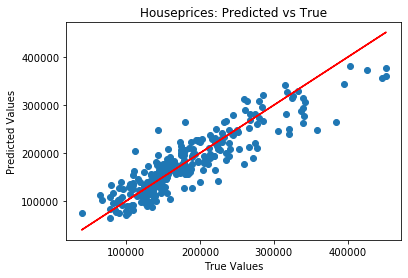

Mean absolute error of the prediction is: 23132.82725834426
Mean squared error of the prediction is: 984599218.5804012
Root mean squared error of the prediction is: 31378.3240244026
Mean absolute percentage error of the prediction is: 13.857177726011283


In [25]:
y_test_pred_2 = results.predict(X_test_2)

plt.scatter(y_test, y_test_pred_2)
plt.plot(y_test, y_test, color='r')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Houseprices: Predicted vs True')
plt.show()


print_evaluation_metrics(y_test, y_test_pred)

Overall, this model was actually slightly worse. The evaluation metrics returned higher values for everything, and a nearly identical percentage of error. Let's go back to the original model and try a different regularization method

## Change Regularization

### Ridge Regression

In [54]:
# Initialize the Ridge Regression Model and test it (use lambda=50)
import sklearn.linear_model as lm

ridgereg = lm.Ridge(alpha=50)
ridgereg.fit(X_train, y_train)

print('R-squared of the model on the training set is: {}'.format(ridgereg.score(X_train, y_train)))
print('----------Test set statistics------------')
print('R-squared of the model on the test set is: {}'.format(ridgereg.score(X_test, y_test)))

R-squared of the model on the training set is: 0.8159069098091274
----------Test set statistics------------
R-squared of the model on the test set is: 0.7910120335039095


In [68]:
# Perform cross-validation to find the best lambda parameter for this test, and reinitialize it with that parameter

from sklearn.model_selection import GridSearchCV

tuned_parameters = [{'alpha': [1, 5, 10, 100, 500, 1000, 10000]}]

clf = GridSearchCV(ridgereg, param_grid=tuned_parameters, cv=5)
clf.fit(X_train, y_train)

print(clf.best_score_)
print(clf.best_estimator_.alpha)

0.8237597115335642
5


In [69]:
# Reinitialize the regression model with the optimal lambda
ridgereg = lm.Ridge(alpha=clf.best_estimator_.alpha)
ridgereg.fit(X_train, y_train)

print('R-squared of the model on the training set is: {}'.format(ridgereg.score(X_train, y_train)))
print('----------Test set statistics------------')
print('R-squared of the model on the test set is: {}'.format(ridgereg.score(X_test, y_test)))

R-squared of the model on the training set is: 0.8418057882313086
----------Test set statistics------------
R-squared of the model on the test set is: 0.8143380081250075


### Lasso's Regression

In [70]:
# Initialize Lasso Regression model and fit it
lassoreg = lm.Lasso(alpha=50)
lassoreg.fit(X_train, y_train)

print('R-squared of the model on the training set is: {}'.format(lassoreg.score(X_train, y_train)))
print('----------Test set statistics------------')
print('R-squared of the model on the test set is: {}'.format(lassoreg.score(X_test, y_test)))

R-squared of the model on the training set is: 0.8443839667352917
----------Test set statistics------------
R-squared of the model on the test set is: 0.8183369546171464


In [71]:
# Perform cv to find best lambda
clf = GridSearchCV(lassoreg, param_grid=tuned_parameters, cv=5)
clf.fit(X_train, y_train)

print(clf.best_score_)
print(clf.best_estimator_.alpha)

0.8204570184601812
100


In [72]:
# Use that parameter as the lambda in the function
lassoreg = lm.Lasso(alpha=clf.best_estimator_.alpha)
lassoreg.fit(X_train, y_train)

print('R-squared of the model on the training set is: {}'.format(lassoreg.score(X_train, y_train)))
print('----------Test set statistics------------')
print('R-squared of the model on the test set is: {}'.format(lassoreg.score(X_test, y_test)))

R-squared of the model on the training set is: 0.8414861713742501
----------Test set statistics------------
R-squared of the model on the test set is: 0.8164665258471355


### ElasticNet Regression

In [73]:
# Initialize ElasticNet Regression model and fit it
elasticreg = lm.ElasticNet(alpha=50, l1_ratio=.5)
elasticreg.fit(X_train, y_train)

print('R-squared of the model on the training set is: {}'.format(elasticreg.score(X_train, y_train)))
print('----------Test set statistics------------')
print('R-squared of the model on the test set is: {}'.format(elasticreg.score(X_test, y_test)))

R-squared of the model on the training set is: 0.48350357901087687
----------Test set statistics------------
R-squared of the model on the test set is: 0.44466587778961275


In [74]:
# Perform cv to find best lambda
clf = GridSearchCV(elasticreg, param_grid=tuned_parameters, cv=5)
clf.fit(X_train, y_train)

print(clf.best_score_)
print(clf.best_estimator_.alpha)
print(clf.best_estimator_.l1_ratio)

0.7650032332688952
1
0.5


In [75]:
# Reinitialize ElasticNet Regression model and fit it
elasticreg = lm.ElasticNet(alpha=clf.best_estimator_.alpha, l1_ratio=clf.best_estimator_.l1_ratio)
elasticreg.fit(X_train, y_train)

print('R-squared of the model on the training set is: {}'.format(elasticreg.score(X_train, y_train)))
print('----------Test set statistics------------')
print('R-squared of the model on the test set is: {}'.format(elasticreg.score(X_test, y_test)))

R-squared of the model on the training set is: 0.7692775485303541
----------Test set statistics------------
R-squared of the model on the test set is: 0.7393498517502833


The best model, according to the adjusted r-squared metric, is the first model I ran, with all my original features, using OLS linear regression. That model also scored the best against test data.